In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet
from pyramid.arima import auto_arima

from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Plotting functions

In [2]:
def plotting_features(exog, mode):
    """
    plotting features
    """
    
    if mode == 'prophet':
        Exog = exog.values
        
    elif mode == 'pyramid':
        Exog = exog

    else:
        print("check mode")
        return None
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots
    
    fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)
    

    ax1.plot(Time,Exog[:,0])
    ax1.set_ylabel('exog_1', bbox=box)


    ax3.set_ylabel('exog_2',bbox=box)
    ax3.plot(Time,Exog[:,1])

    labelx = -0.3  # axes coords

    ax2.plot(Time,Exog[:,2])
    ax2.set_ylabel('exog_3', bbox=box)
    ax2.yaxis.set_label_coords(labelx, 0.5)


    ax4.plot(Time,Exog[:,3])
    ax4.set_ylabel('exog_4', bbox=box)
    ax4.yaxis.set_label_coords(labelx, 0.5)

    plt.show()
    
    pass

In [3]:
def plotting_time_series(y_without_lags, y_with_lags, mode):
    """
    Plot two time series
    """
    if mode == 'prophet':
        ts_without_lags = data_without_lags["y"].values
        ts_with_lags = data_with_lags["y"].values
        
    elif mode == 'pyramid':
        ts_without_lags = y_without_lags
        ts_with_lags = y_with_lags
        
    else:
        print("Check mode")
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (3, 7))
    fig.subplots_adjust(top = 2, bottom = 1,  right = 2, left = 0, hspace = 0.2)

    ax1.plot(Time, ts_without_lags)
    ax1.set_ylabel("value", bbox = box)
    ax1.set_title("y without lags", bbox = box)


    ax2.set_ylabel("value", bbox = box)
    ax2.plot(Time, ts_with_lags)
    ax2.set_title("y with lags", bbox = box)

    #fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.show()
    
    pass

In [4]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, mode, description):
    
    """
    Plots the original time series and it prediction
    """
    if mode == 'prophet':
        ts = time_series["y"].values
        train_pr = train_prediction["yhat"].values
        test_pr = test_prediction["yhat"].values
    
    elif mode == 'pyramid':
        train_pr = train_prediction
        test_pr = test_prediction
        ts = time_series
        
    
    else:
        print("Check mode")
        return None
    
    plt.figure(figsize=(10,7))

    plt.plot(Time, ts, label = "true")
    
    plt.plot(Time[start_point+1: end_point], np.concatenate([train_pr, test_pr])[1:], 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3)))


    plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

# Extra functions

In [5]:
def generate_problem_synthetic_2_AR(n_elements, mode = 'prophet', seed = 123, noise_scale = None):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([f_1(Time,2,1,1,0.1,0), 
                           f_1(Time,1,0.5,0.2,-0.1,0.01), 
                           f_1(Time,1,0.6,1,0.5,0.02),
                           f_1(Time,1,0.7,0.5,0.5,-0.02) + 10,
                           
                           f_1(Time,10,0.3,0.5,1,+0.05) + 10,
                           f_1(Time,5,0.85,1,2,-0.01) + 5,
                           f_1(Time,1,0.5,3,0,0.05) + 10], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_1(Exog,noise_scale=noise_scale)
    
    y_with_lags = generate_ts_2(Exog,noise_scale=noise_scale)
    
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog)
        exog.columns = ["f1", "f2", "f3", "f4","f5", "f6", "f7"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [6]:
def train_test_split(data, start_point, middle_point, end_point, mode, exog_flag = False):
    """
    Make train-test-split using input parameters
    """
    
    if mode == 'prophet':
        data_train = data.iloc[start_point: middle_point].copy()
        data_test = data.iloc[middle_point: end_point].copy()
        
        
        if exog_flag == False:
            
            y_test = data_test["y"].values
            del data_test["y"]
            
            return data_train, data_test, y_test
        
        else:
            
            return data_train, data_test
    
    elif mode == 'pyramid':
        
        data_train = data[start_point: middle_point]
        data_test = data[middle_point: end_point]
        
        if exog_flag == False:
            return data_train, data_test, data_test
        else:
            return data_train, data_test
        
    else:
        print("Check mode")
        return None, None, None

In [7]:
def Fit(mode, data_train, exog_train = None, params = None):
    
    """
    Fit the models
    """
    
    if mode == 'prophet':
        model = fit_prophet(data_train = data_train, exog_train = exog_train, params = params)
        
    elif mode == 'pyramid':
        model = fit_pyramid(data_train = data_train, exog_train = exog_train, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [8]:
def Predict(mode, model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Model prediction on train and test
    """
    
    if mode == 'prophet':
        model = predict_prophet(model = model, data_train = data_train, data_test = data_test, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    elif mode == 'pyramid':
        model = predict_pyramid(model = model, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [9]:
def fit_prophet(data_train, exog_train = None, params = None):
    
    """
    Method fit for prophet
    """
    
    data_train_new = data_train.copy()
    
    model = Prophet()
    
    if exog_train is not None:
        
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        
        model.add_regressor("f1")
        model.add_regressor("f2")
        model.add_regressor("f3")
        model.add_regressor("f4")
        model.add_regressor("f5")
        model.add_regressor("f6")
        model.add_regressor("f7")

    model.fit(data_train_new)
    
    return model

In [10]:
def predict_prophet(model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Prediction for prophet
    """
    
    data_test_new = data_test.copy()
    data_train_new = data_train.copy()
    
    if exog_train is not None:
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        data_test_new = pd.merge(data_test_new, exog_test, on = "ds")
    
    forecast_train = model.predict(data_train_new)
    forecast_test = model.predict(data_test_new)
    
    return forecast_train, forecast_test

In [11]:
def fit_pyramid(data_train, exog_train = None, params = None):

    """
    pyramid_mode {"stepwise", "random_search"}

    """
    
    if params['pyramid_mode'] == "stepwise":
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5,
        m=params['period'], n_jobs = params['n_jobs'], scoring = params['scoring'], 
        out_of_sample_size = params['out_of_sample_size'], 
        start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, stepwise=True)
    
    elif params['pyramid_mode'] == 'random_search':
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5, 
        m=params['period'], scoring = params['scoring'], out_of_sample_size = params['out_of_sample_size'],
        start_P=0, start_Q = 0, n_jobs=params['n_jobs'], max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, 
        stepwise=False, random=True, random_state=params['random_state'], n_fits = params['n_fits'])
    
    return model

In [12]:
def predict_pyramid(model, exog_train = None, exog_test = None, params = None):
    
    predict_in_sample = model.predict_in_sample(exogenous = exog_train, dynamic = params['dynamic'])
    predict_out_of_sample = model.predict(n_periods = params['n_periods'], exogenous = exog_test)
    
    return predict_in_sample, predict_out_of_sample

# Data generation functions

In [13]:
def f_1(time,start,k,sigma,c,ct,seed = 123):
    """
    time: np.array (len_ts,)
    k: parameter of AR(1)
    sigma: variance of noise
    c: constant part of trend
    ct : koef of linear part of trend
    """
    len_ts = time.shape[0]
    np.random.seed(seed)
    f = np.empty(len_ts)
    f[0] = start
    w = np.random.normal(size = len_ts, scale = sigma)
    for i in range(1,len_ts):
        f[i] = k * f[i-1] + c + ct * i + w[i]    
    return f.reshape(-1,1)

def generate_ts_1(exog, noise_scale = None):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = a = np.array([0.25,0.25,0.25,0.25,0,0,0]).reshape(-1,1)
    y = exog @ a
    y = y.squeeze()
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y

def generate_ts_2(exog, noise_scale = None):
    
    y = np.zeros(exog.shape[0])
    a = a = np.array([0.25,0.25,0.25,0.25,0,0,0]).reshape(-1,1)
    
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y


def generate_ts_nonlinear(exog, noise_scale = None):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 1] * exog[:, 2] + exog[:, 2] / exog[:, 3]
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y

def generate_ts_nonlinear_with_lags(exog, noise_scale = None):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 0] * exog[:, 2] + exog[:, 1] / exog[:, 2]
    
    for i in range(2, exog.shape[0]):
        
        y[i] = y[i] + 0.2 * y[i-1] + 0.2 * y[i-2] + 0.1 * y[i-1]
    
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
        
    return y


# Testing on the last dataset - linear case

# Prophet

In [14]:
# Global_mode
global_mode = 'prophet'
noise_scale = None

# Generate problem

In [15]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, 
                        mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

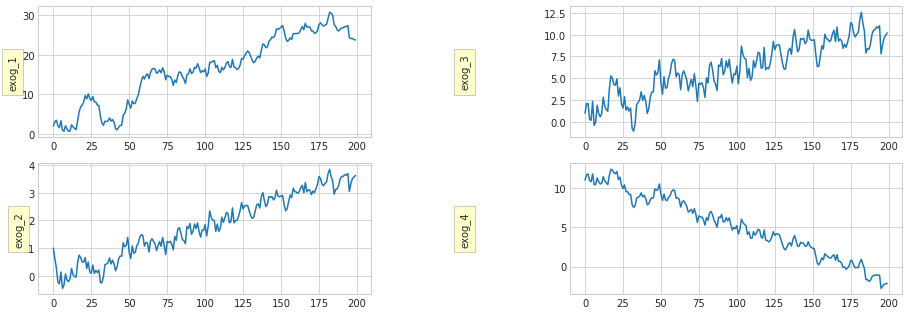

In [16]:
plotting_features(exog, global_mode)

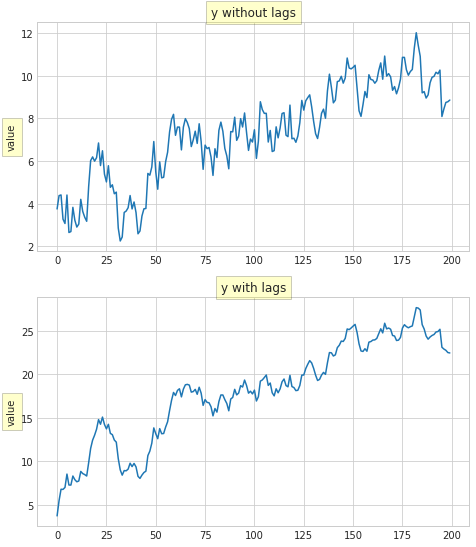

In [17]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [18]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet without lags without noise with exogs 

In [19]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [20]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

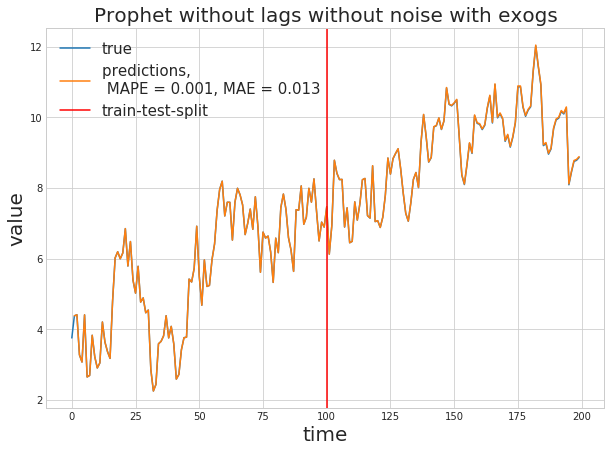

In [21]:
description = "Prophet without lags without noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

In [23]:
model.params

{'k': array([[0.21357801]]),
 'm': array([[0.59870004]]),
 'delta': array([[-4.99036222e-03, -6.26389144e-03, -2.07820440e-02,
         -2.01860844e-02, -1.43642443e-02, -2.35089503e-03,
         -7.93758717e-04, -1.19363308e-02, -1.05581254e-03,
          3.36064823e-03, -3.38926224e-05,  1.24249134e-03,
          1.33036066e-02, -2.69483806e-04, -7.81785270e-03,
         -6.70172481e-04, -1.66997328e-03, -1.32664231e-02,
         -1.06630232e-03, -1.58054666e-03,  3.10109218e-04,
          2.36912906e-04,  3.20185727e-04,  2.44187321e-04,
          1.39909117e-02]]),
 'sigma_obs': array([[0.00029035]]),
 'beta': array([[-4.37874031e-05, -4.65597791e-05,  1.89950761e-05,
          9.87609169e-05,  1.60290353e-05, -1.53362911e-04,
         -9.30929081e-05,  8.55290159e-05,  6.42716476e-05,
         -7.95016949e-05,  2.11687180e-05,  5.76580436e-06,
          5.07819769e-05,  9.85486407e-05, -4.73384617e-05,
         -1.06447498e-04, -2.86221859e-05,  1.50975956e-04,
          4.7473631

# Prophet with lags without noise with exogs

In [27]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [28]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

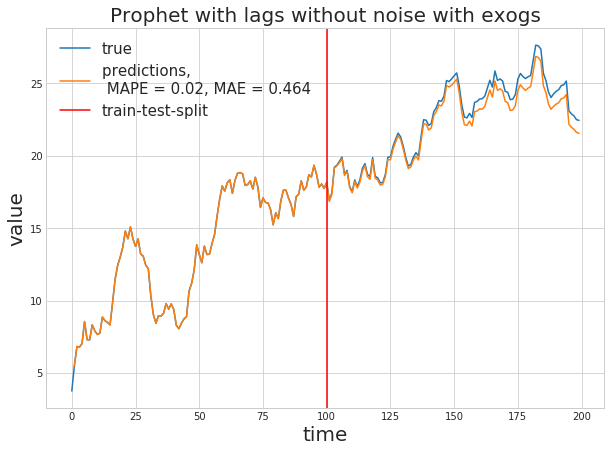

In [29]:
description = "Prophet with lags without noise with exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid Approach

In [142]:
# Global_mode
global_mode = 'pyramid'
noise_scale = None

# Generate problem

In [143]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, 
                                mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

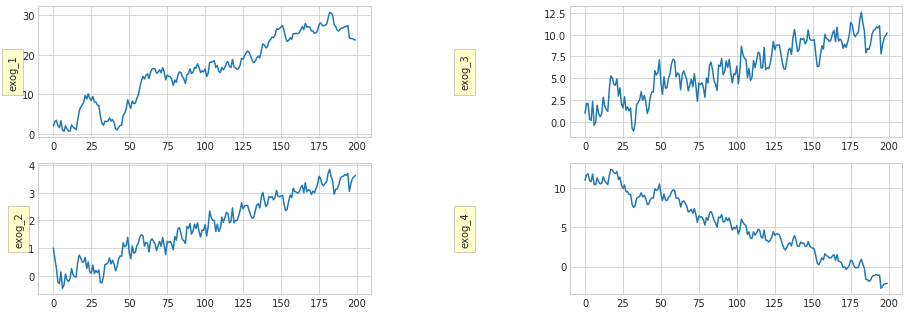

In [144]:
plotting_features(exog, global_mode)

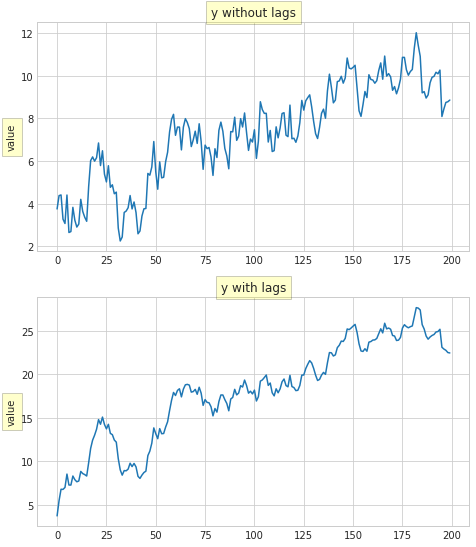

In [145]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [146]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Pyramid without lags without noise without exogs

In [147]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [148]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -111.999
Date:                Thu, 19 Jul 2018   AIC                            231.998
Time:                        15:33:15   BIC                            242.378
Sample:                             0   HQIC                           236.198
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0090      0.004      2.359      0.018       0.002       0.016
ar.L1          0.7799      0.082      9.528      0.000       0.619       0.940
ma.L1         -0.9999     22.397     -0.045      0.964     -44.898      42.898
sigma2         0.5481     12.270      0.045      0.964     -23.501      24.597
===================================================================================
Ljung-Box (Q):                       47.59   Jarque-Bera (JB):                 2.26
Prob(Q):                              0.19   Prob(JB):                         0.32
Heteroskedasticity (H):               0.74   Skew:                             0.00
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [149]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

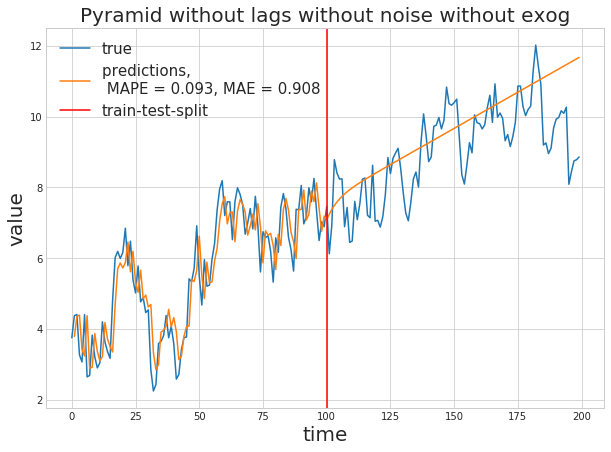

In [150]:
description = "Pyramid without lags without noise without exog"
plot_results(data_without_lags, Time, train_prediction, 
             test_prediction, y_test_without_lags, global_mode, description)

# Pyramid without lags without noise with exog

In [151]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

In [152]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

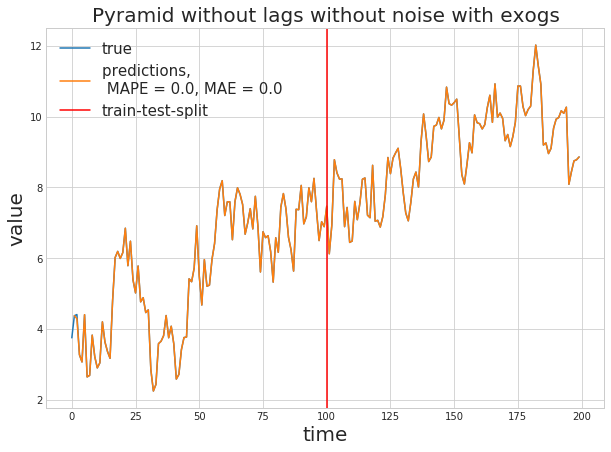

In [153]:
description = "Pyramid without lags without noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, 
             global_mode, description)

# Pyramid with lags without noise without exogs

In [154]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -117.557
Date:                Thu, 19 Jul 2018   AIC                            239.114
Time:                        15:33:16   BIC                            244.304
Sample:                             0   HQIC                           241.214
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1414      0.080      1.771      0.077      -0.015       0.298
sigma2         0.6294      0.106      5.925      0.000       0.421       0.838
===================================================================================
Ljung-Box (Q):                       45.53   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.25   Prob(JB):                         0.49
Heteroskedasticity (H):               0.60   Skew:                             0.06
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

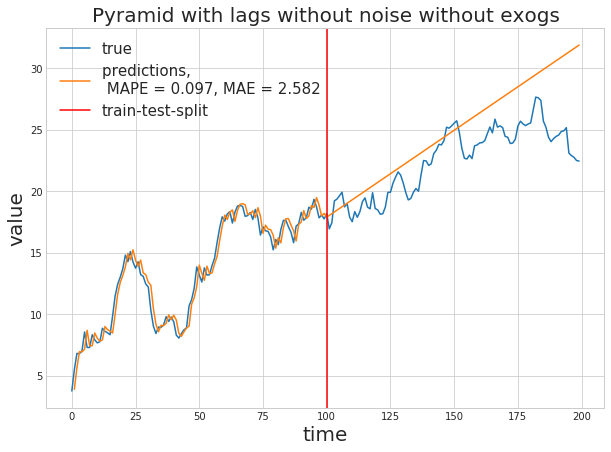

In [156]:
description = "Pyramid with lags without noise without exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid with lags without noise with exog

In [157]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

In [158]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 158.215
Date:                Thu, 19 Jul 2018   AIC                           -292.430
Time:                        15:33:21   BIC                           -261.168
Sample:                             0   HQIC                          -279.778
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5037      0.114      4.400      0.000       0.279       0.728
x1             0.6297      0.014     46.196      0.000       0.603       0.656
x2            -7.5750      0.415    -18.233      0.000      -8.389      -6.761
x3             1.1801      0.124      9.555      0.000       0.938       1.422
x4            -0.8945      0.028    -31.578      0.000      -0.950      -0.839
x5             0.6160      0.043     14.301      0.000       0.532       0.700
x6             0.2936      0.025     11.551      0.000       0.244       0.343
x7             0.0790      0.030      2.660      0.008       0.021       0.137
ar.L1          1.3188      0.110     12.011      0.000       1.104       1.534
ar.L2         -0.7373      0.125     -5.888      0.000      -0.983      -0.492
ar.L3          0.1881      0.074      2.559      0.010       0.044       0.332
sigma2         0.0022      0.000      5.227      0.000       0.001       0.003
===================================================================================
Ljung-Box (Q):                       44.56   Jarque-Bera (JB):               206.46
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

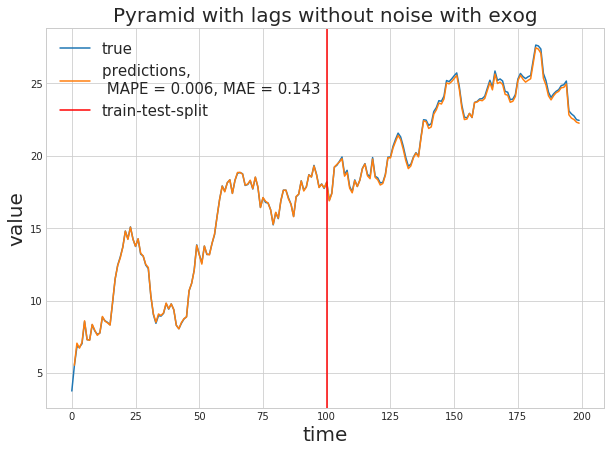

In [160]:
description = "Pyramid with lags without noise with exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise

# Testing on the last dataset - linear case - with noise

# Prophet

In [31]:
# Global_mode
global_mode = 'prophet'
noise_scale = 0.05

# Generate problem

In [32]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, 
                        mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

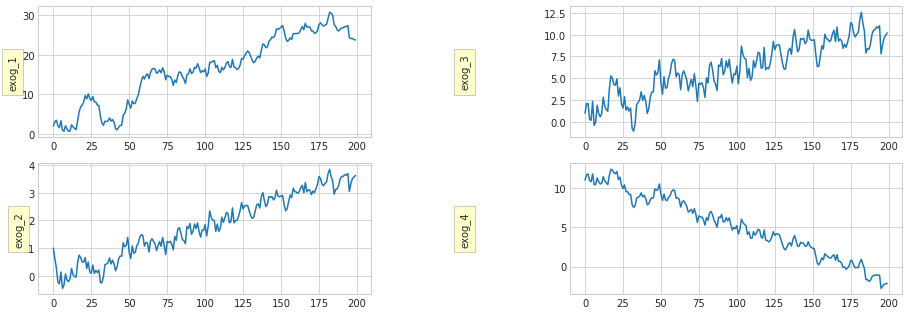

In [33]:
plotting_features(exog, global_mode)

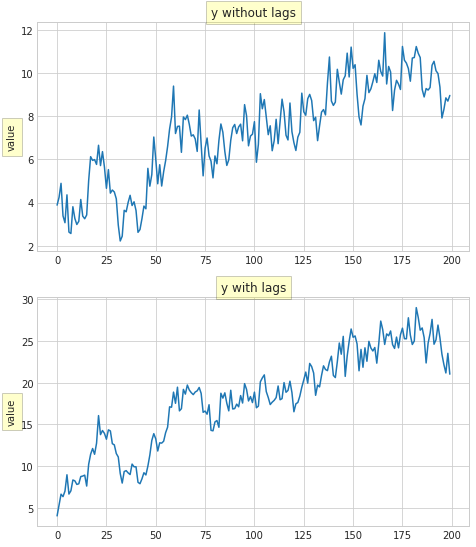

In [34]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [35]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet without lags with noise with exogs 

In [36]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [37]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

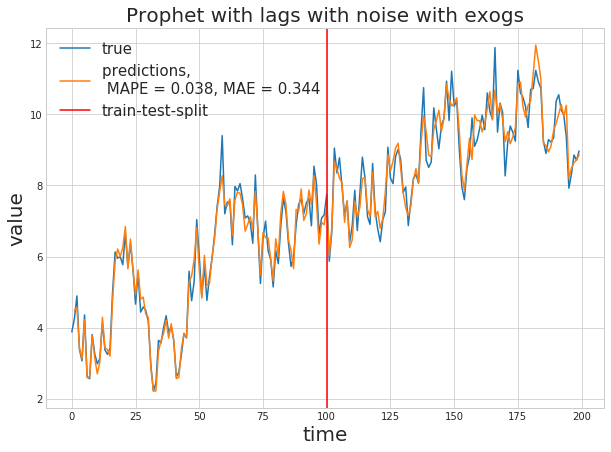

In [38]:
description = "Prophet with lags with noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

In [39]:
model.params

{'k': array([[0.31849692]]),
 'm': array([[0.43325247]]),
 'delta': array([[ 6.40557597e-10,  3.37509821e-09,  1.02448142e-09,
          4.54309870e-09, -8.99673023e-10,  4.30711454e-09,
          4.04463151e-05,  8.43942065e-07,  5.32248139e-09,
          2.69052569e-09,  7.23015846e-10,  1.22354166e-08,
         -3.64454957e-09, -2.25339903e-09,  4.67713201e-09,
         -6.37307218e-09, -4.33721146e-09, -3.52985520e-09,
          1.07580645e-09, -5.41202568e-09,  3.51921812e-10,
          1.48850492e-10,  2.97655105e-09,  1.44369052e-06,
          1.00224115e-08]]),
 'sigma_obs': array([[0.02960301]]),
 'beta': array([[ 0.00494533,  0.00317596,  0.01302533,  0.00940149,  0.01274444,
         -0.00650408,  0.00428608,  0.06196054, -0.02920454,  0.01810849,
          0.06773465,  0.01282254, -0.02111159, -0.03173922,  0.0201974 ,
         -0.05892266, -0.00393206,  0.0065001 ,  0.01198192, -0.00346117,
          0.14109579,  0.13997766, -0.02361399,  0.14415224, -0.05137152,
         

# Prophet with lags with noise with exogs

In [40]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [41]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

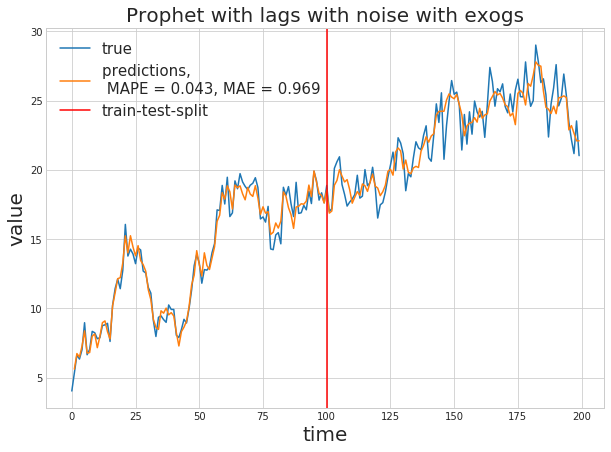

In [42]:
description = "Prophet with lags with noise with exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid Approach

In [178]:
# Global_mode
global_mode = 'pyramid'
noise_scale = 0.05

# Generate problem

In [179]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, 
                                mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

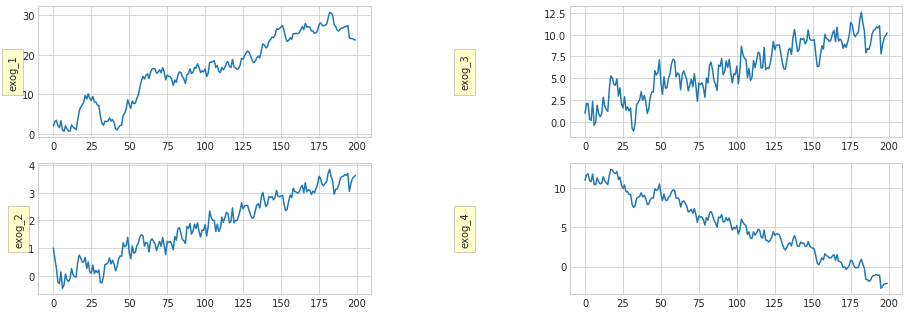

In [180]:
plotting_features(exog, global_mode)

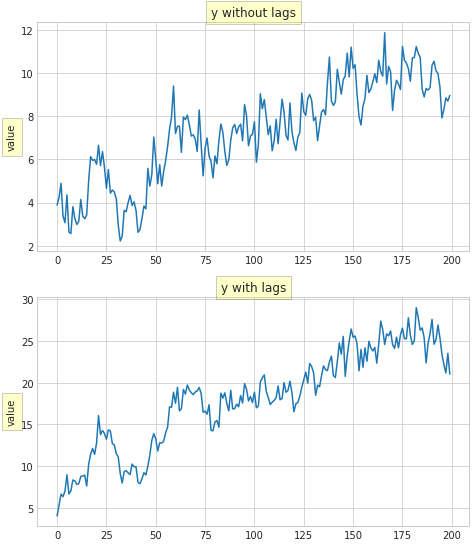

In [181]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [182]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Pyramid without lags with noise without exogs

In [183]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [184]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -120.497
Date:                Thu, 19 Jul 2018   AIC                            250.995
Time:                        15:33:45   BIC                            263.970
Sample:                             0   HQIC                           256.245
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0494      0.083      0.598      0.550      -0.112       0.211
ar.L1         -0.5437      0.272     -1.998      0.046      -1.077      -0.010
ma.L1          0.3184      0.246      1.294      0.196      -0.164       0.801
ma.L2         -0.3570      0.102     -3.497      0.000      -0.557      -0.157
sigma2         0.6662      0.114      5.843      0.000       0.443       0.890
===================================================================================
Ljung-Box (Q):                       32.95   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.78   Prob(JB):                         0.40
Heteroskedasticity (H):               0.96   Skew:                             0.18
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [185]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

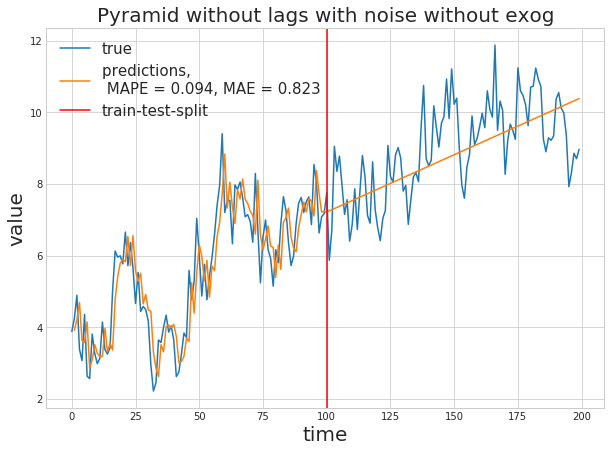

In [186]:
description = "Pyramid without lags with noise without exog"
plot_results(data_without_lags, Time, train_prediction, 
             test_prediction, y_test_without_lags, global_mode, description)

# Pyramid without lags with noise with exog

In [187]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

In [188]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

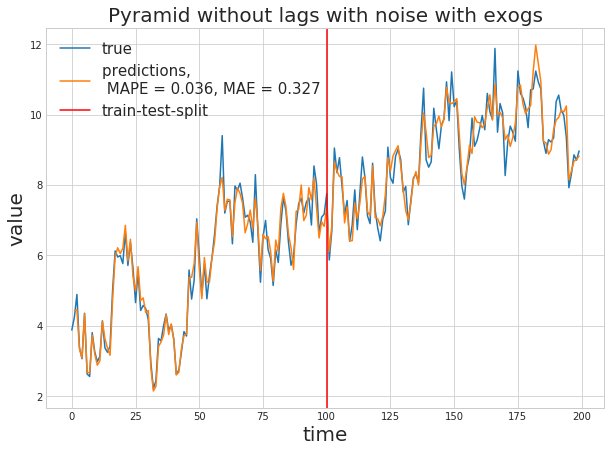

In [189]:
description = "Pyramid without lags with noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, 
             global_mode, description)

In [190]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                 -19.367
Date:                Thu, 19 Jul 2018   AIC                             56.734
Time:                        15:33:47   BIC                             80.181
Sample:                             0   HQIC                            66.224
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3853      5.210      0.074      0.941      -9.826      10.596
x1             0.2404      0.021     11.285      0.000       0.199       0.282
x2             0.6154      2.499      0.246      0.805      -4.282       5.513
x3             0.4836      0.540      0.895      0.371      -0.575       1.542
x4             0.3327      0.125      2.654      0.008       0.087       0.578
x5            -0.0216      0.422     -0.051      0.959      -0.849       0.806
x6            -0.0116      0.082     -0.140      0.889      -0.173       0.150
x7            -0.1129      0.096     -1.178      0.239      -0.301       0.075
sigma2         0.0862      0.013      6.768      0.000       0.061       0.111
===================================================================================
Ljung-Box (Q):                       41.75   Jarque-Bera (JB):                18.11
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Pyramid with lags with noise without exogs

In [191]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -163.183
Date:                Thu, 19 Jul 2018   AIC                            332.365
Time:                        15:33:48   BIC                            340.151
Sample:                             0   HQIC                           335.515
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1359      0.100      1.358      0.174      -0.060       0.332
ma.L1         -0.2244      0.103     -2.176      0.030      -0.427      -0.022
sigma2         1.5812      0.213      7.429      0.000       1.164       1.998
===================================================================================
Ljung-Box (Q):                       30.44   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.86   Prob(JB):                         0.51
Heteroskedasticity (H):               1.02   Skew:                             0.24
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [192]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

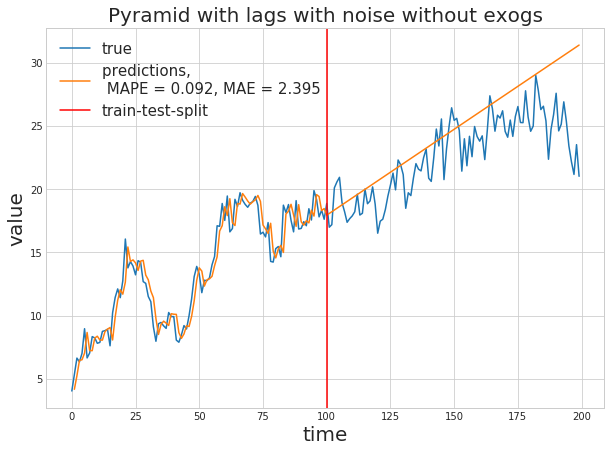

In [193]:
description = "Pyramid with lags with noise without exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid with lags with noise with exog

In [194]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

In [195]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                -111.505
Date:                Thu, 19 Jul 2018   AIC                            241.010
Time:                        15:33:49   BIC                            264.456
Sample:                             0   HQIC                           250.499
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.307e-05     22.546    2.8e-06      1.000     -44.189      44.189
x1             0.6292      0.055     11.371      0.000       0.521       0.738
x2            -7.2569     10.885     -0.667      0.505     -28.592      14.078
x3             1.1208      1.826      0.614      0.539      -2.458       4.699
x4            -0.8605      0.686     -1.255      0.209      -2.204       0.483
x5             0.7256      1.809      0.401      0.688      -2.821       4.272
x6             0.3440      0.181      1.901      0.057      -0.011       0.699
x7             0.0431      0.325      0.132      0.895      -0.594       0.680
sigma2         0.5446      0.071      7.699      0.000       0.406       0.683
===================================================================================
Ljung-Box (Q):                       51.93   Jarque-Bera (JB):                 6.58
Prob(Q):                              0.10   Prob(JB):                         0.04
Heteroskedasticity (H):               2.92   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [196]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

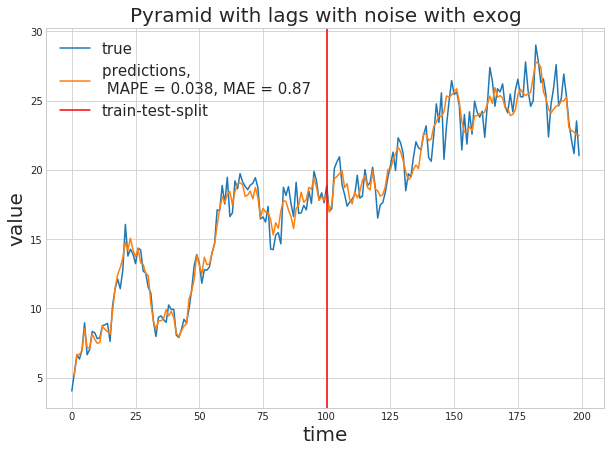

In [197]:
description = "Pyramid with lags with noise with exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)